In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.path.insert(0, './simile')

import importlib
import simile as sml
importlib.reload(sml)

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from rdkit.Chem import MolFromSmiles, rdFMCS, MolToInchiKey

## Load Example Data

In [2]:
mzi = []
pmz = []
mols = []
spec_name = None
tolerance = .01

for ex in ['1','5a','5b','5c']:
    df = pd.read_json('./example_data/fig{}.json'.format(ex))
    mzi.append(np.array((df.iloc[0].spectrum)))
    mzi.append(np.array((df.iloc[1].spectrum)))

    pmz.append(df.iloc[0].precursor_mz)
    pmz.append(df.iloc[1].precursor_mz)

    mols.append(MolFromSmiles(df.iloc[0].smiles))
    mols.append(MolFromSmiles(df.iloc[1].smiles))


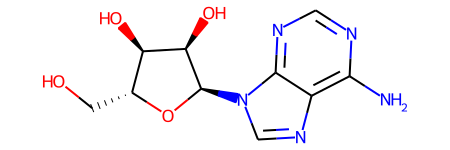

In [3]:
mols[6]

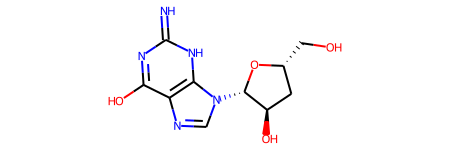

In [4]:
mols[7]

In [5]:
res = rdFMCS.FindMCS([mols[0],mols[1]],timeout=10,ringMatchesRingOnly=False)
A = mols[0].GetNumBonds()
B = mols[1].GetNumBonds()
AB = res.numBonds 
jaccard_similarity = AB / (A+B-AB)
jaccard_similarity

0.5714285714285714

## Generate Synthetic Data

In [6]:
mzi = []
pmz = []
mols = []
spec_name = []
tolerance = .01

a = 20 + np.random.random_sample()/10
b = 8  + np.random.random_sample()/10
c = 5  + np.random.random_sample()/10
d = 1  + np.random.random_sample()/10

mzi.append(np.array([[c,b,a,a+c,a+b,a+b+c]
                for i in range(2)]))
pmz.append(mzi[-1][0].max())
spec_name.append('none')

mzi.append(np.array([[c,b+d,a,a+c,a+b+d,a+b+c+d]
                for i in range(2)]))
pmz.append(mzi[-1][0].max())
spec_name.append('b')


mzi.append(np.array([[c,c+d,b,b+d,a,a+c+d,a+b+d,a+b+c+d,a+b+c+2*d]
                 for i in range(2)]))
pmz.append(mzi[-1][0].max())
spec_name.append('b+c')


mzi.append(np.array([[c+d,b,a,a+c+d,a+b,a+b+c+d]
                 for i in range(2)]))
pmz.append(mzi[-1][0].max())
spec_name.append('c')


## Load GNPS Data

In [7]:
mzi = []
pmz = []
mols = []
spec_name = None
tolerance = .33


import requests
url1 = 'https://metabolomics-usi.ucsd.edu/json/?usi1=mzspec:GNPS:TASK-e3642744dc754c73ab780797577c62d2-spectra/specs_ms.mgf:scan:2021'
url2 = 'https://metabolomics-usi.ucsd.edu/json/?usi1=mzspec:GNPS:TASK-e3642744dc754c73ab780797577c62d2-spectra/specs_ms.mgf:scan:2025'

r = requests.get(url1)
mzi.append(np.asarray(r.json()['peaks']).T)
pmz.append(r.json()['precursor_mz'])

r = requests.get(url2)
mzi.append(np.asarray(r.json()['peaks']).T)
pmz.append(r.json()['precursor_mz'])


## SIMILE Substitution Matrix, Alignment Score, and Alignment P-value

### Select Spectra

In [8]:
## Subsample spectra of interest by slicing 
mzs = np.array([mz for (mz,i) in mzi])#[[4,5]]
pmzs = np.array(pmz)#[[4,5]]

/Users/dgct/anaconda/envs/simile/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


### Run SIMILE

Scores: (0.41265069675101385, 0.6649852842811574), P-value: 3e-06, Matches: (124, -201)


/Users/dgct/anaconda/envs/simile/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


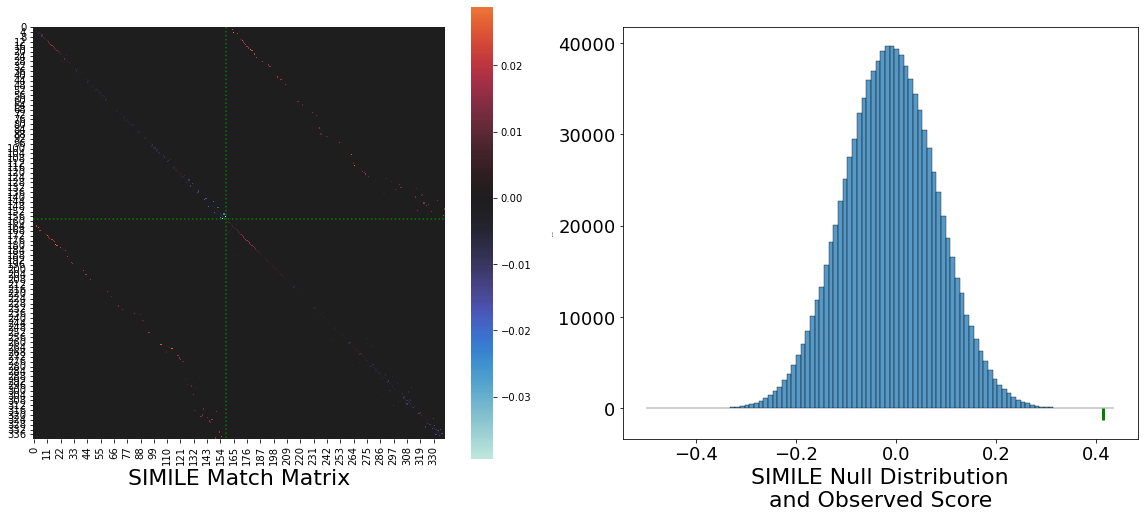

In [9]:
%matplotlib inline
importlib.reload(sml)

## SIMILE ##############################################################################################################
S, spec_ids = sml.similarity_matrix(mzs, pmzs=pmzs, tolerance=tolerance)

C = sml.inter_intra_compare(spec_ids)

## Set comparisons so only consecutive spectra are "good"
# C = 2*np.maximum(np.equal.outer(spec_ids,spec_ids+1),
#                  np.equal.outer(spec_ids,spec_ids-1))-1

## Each fragment ion can only match once
M = sml.pairwise_match(S)

## Each fragment ion can only match once per fragmentation spectra
# M = sml.multiple_match(S,spec_ids)

scores, probs = sml.match_scores(S,C,M, spec_ids, gap_penalty=4)
pro = scores.clip(0).sum()
con = -scores.clip(None,0).sum()

pval,null_dist = sml.mcp_test(scores, probs, return_dist=True, log_size=6)

## Plotting ###########################################################################################################
print('Scores: {}, P-value: {}, Matches: {}'.format((pro-con,pro/(pro+con)),pval, (((M*C)>0).sum(),-((M*C)<0).sum())))
fig,ax= plt.subplots(1,2,figsize=(16,16))
sns.heatmap(S*C*M+np.diag(scores), 
            cbar_kws={"shrink": .4},
            center=0,linewidths=0.0, rasterized=True, ax=ax[0])
ax[0].xaxis.set_label_text('SIMILE Match Matrix', fontsize=22)
ax[0].vlines(np.argwhere(spec_ids[:-1] != spec_ids[1:]).flatten()+1, 0, len(spec_ids), color='g', linestyle=':')
ax[0].hlines(np.argwhere(spec_ids[:-1] != spec_ids[1:]).flatten()+1, 0, len(spec_ids), color='g', linestyle=':')
ax[0].set_aspect(1.0/ax[0].get_data_ratio(), adjustable='box')


sns.histplot(null_dist.real, ax=ax[1], stat='count',bins=100)
ax[1].xaxis.set_label_text('SIMILE Null Distribution\nand Observed Score', fontsize=22)
ax[1].yaxis.set_label_text('Count', fontsize=2)
ax[1].xaxis.set_tick_params(labelsize=18)
ax[1].yaxis.set_tick_params(labelsize=18)
ax[1].vlines((pro-con),0,-ax[1].get_ylim()[1]/33,color='g',linewidth=3)
ax[1].set_aspect(.8/ax[1].get_data_ratio(), adjustable='box')

fig.tight_layout()
fig.show()

In [10]:
pd.set_option('display.max_rows', 500)
df = sml.matching_ions_report(S, C, M, mzs, pmzs, spec_name).sort_values(['type', 'score'], ascending=False)
df.round(3)

,spec_key_1,spec_key_2,pmz_1,pmz_2,mz_1,mz_2,mz_diff,nl_diff,score,type
5,0,1,855.149,854.329,272.079,272.164,-0.085,0.905,0.029,pro
19,0,1,855.149,854.329,313.329,313.415,-0.086,0.906,0.028,pro
11,0,1,855.149,854.329,298.387,298.258,0.129,0.691,0.027,pro
89,0,1,855.149,854.329,821.445,821.568,-0.123,0.943,0.026,pro
80,0,1,855.149,854.329,809.481,809.640,-0.159,0.979,0.026,pro
20,0,1,855.149,854.329,314.205,314.295,-0.090,0.910,0.024,pro
2,0,1,855.149,854.329,265.085,264.996,0.089,0.731,0.024,pro
127,0,1,855.149,854.329,1505.388,1521.452,-16.064,NaN,0.023,pro
16,0,1,855.149,854.329,310.963,310.057,0.906,-0.086,0.022,pro
6,0,1,855.149,854.329,282.259,282.249,0.010,0.810,0.021,pro
